## COG403: Problem 3 of Problem Set 1: Surprisal

### All 3 problems for Problem Set 1 Due 4 October 2018

**Note**: To edit this notebook, click "clone", and it will prompt you to create your own copy of this library. Make sure to create a private library, so others can't see your answers. For more details, see the How-To Guide for Azure Notebooks posted on Quercus.


In [4]:
# This installs a Python library called arpa, which is used for loading arpa format language files.
# For more information, see: https://pypi.org/project/arpa/
# Run this cell before running other cells in this notebook that use the arpa library.

!pip install arpa
import arpa

# Here are some examples of how to use arpa:

demo_model = arpa.loadf("data/bnc_10k_with_smoothing.arpa")[0]

# demo_model.p will give you the conditional probability of the last item given what came before
print("P(there|hi) = {:.4f}".format(demo_model.p(["hi", "there"])))

# You can pass a list of terms or a string (arpa will automatically split on spaces).
print("P(there|hi) = {:.4f}".format(demo_model.p("hi there")))

# demo_model.log_p will give you log probabilities
print("log_p(there|hi) = {:.4f}".format(demo_model.log_p(["hi", "there"])))

# demo_model.vocabulary() will return the vocabulary of the language model
print("'hi' in demo_model.vocabulary() = {:.4f}".format("hi" in demo_model.vocabulary()))

# For this problem set, the arpa models are bigram models. Arpa models will not raise an error
# when passed trigrams, but the probabilities are not correct. It actually returns the bigram
# probability of the last two tokens in the input.
print("P(there|well hi) != {:.4f}".format(demo_model.p(["well", "hi", "there"])))  # same output as demo_model.p([hi", "there"])

# Note that all input to the arpa model should be lowercase. The following will raise an error:
# demo_model.p(["Hi"])

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
P(there|hi) = 0.0025
P(there|hi) = 0.0025
log_p(there|hi) = -2.5984
'hi' in demo_model.vocabulary() = 1.0000
P(there|well hi) != 0.0025


## Part 1: Understanding Surprisal

Smith and Levy$^1$ explored the shape of the relationship between a word’s predictability in context and how long, on average, a comprehender spends on reading that word. In particular they were interested in the hypothesis that a word’s average reading time might be linear in the surprisal of the word (Hale, 2001; Levy, 2008):

$$\textrm{surprisal}(w_i|\textrm{Context}) = \log\frac{1}{P(w_i|\textrm{Context})} \quad\quad (1)$$

or in some other function of the word’s conditional probability. In this assignment, you will investigate this question yourself, using one of the datasets analyzed by Smith and Levy.

### (a)

Write a function to compute the surprisal of a bigram using a bigram arpa model. In the case of out of vocabulary (OOV) items (words that don't occur in our training corpus), return None.

Compute the surprisal of the word "toast" in the bigram "like toast" using the bigram arpa model trained on the British National Corpus (BNC)$^2$ with smoothing.

In [86]:
import arpa
import numpy as np

# model_with_smoothing = arpa.loadf("data/bnc_10k_with_smoothing.arpa")[0]
# vocab = set(model_with_smoothing.vocabulary())

def compute_surprisal(arpa_model, bigram, vocab):
    """
    Return the surprisal of the second word in bigram based on bigram probabilities. Return None when
    one of the words in bigram is an OOV word.
    """
    
    for word in bigram:
        if word not in vocab:
            return None

    cond_prob = arpa_model.p(bigram)
    suprisal = np.log(1 / cond_prob)
    
    return suprisal

# print(compute_surprisal(model_with_smoothing, ['like', 'toast'], vocab))

### (b) 

Compute the surprisal of the word "toast" in the bigram "like toast" using a bigram model trained on the BNC without smoothing. Is the surprisal of word "toast" based on the smoothing higher or lower than that of the model without smoothing? Explain why you think this is.

If it's lower, come up with an example that would have higher surprisal without smoothing than with smoothing. If it's higher, come up with an example of a bigram that would have a lower surprisal without smoothing than with smoothing.  Explain how you came up with that example.

Hint: investigate the arpa file to see which bigrams occur in the corpus.

In [90]:
corpus_path = "data/bnc_10k_no_smoothing.arpa"

model_without_smoothing = arpa.loadf(corpus_path)[0]
model_with_smoothing = arpa.loadf("data/bnc_10k_with_smoothing.arpa")[0]

vocab_without_smoothing = set(model_without_smoothing.vocabulary())
vocab_with_smoothing = set(model_with_smoothing.vocabulary())


# # print(vocab)

print("Without Smoothing:")
print(compute_surprisal(model_without_smoothing, ['and', 'toast'], vocab_without_smoothing))
print("With Smoothing:")
print(compute_surprisal(model_with_smoothing, ['and', 'toast'], vocab_with_smoothing))


Without Smoothing:
8.406484890161032
With Smoothing:
10.058847583914675


## Part 2: Surprisal and Reading Times

### (c)

Write a function to load in the Brown Corpus$^3$ annotated with reading times.

In `data/brown_reading_times.csv`, you can access the Smith and Levy$^1$ self-paced reading dataset. This dataset derives from each subject in the experiment reading a number of several-hundred-word passages selected from the
Brown corpus. This dataset is presented in tabular format, with one reading-time measurement per row and with the following columns:

 * The **word** that was read;
 * A **code** that uniquely identifies the word/context pair;
 * The identifier for the **subject** in the experiment from which the reading-time measurement was taken;
 * **text_id**, which is the identifier for the text from the Brown corpus that was being read;
 * **text_pos**, which is the word number in the text selection that was being read;
 * **word_in_exp** is the word number in the experiment for the particular subject;
 * The **time** in milliseconds that the word in question was visible on-screen during the subject’s reading. (Remember, in self-paced reading this is the time elapsed between the subject pressing a button/key to reveal the word, and the subject pressing the button/key again to mask that word and reveal the next word.)

Take a look at the function `get_sentences_and_reading_times` in `provided_functions.py`. Run this function on `data/brown_reading_times.csv`.

Write a function `get_reading_times_and_bigrams` to generate a list of bigrams and reading times for the second word in the bigram. Run it on the sentences and reading times returned by `get_sentences_and_reading_times`. Use the BNC at `data/bnc_10k.txt` as your train corpus (this is used to compute bigram counts for thresholding as described in the docstring for `get_reading_times_and_bigrams` below).

Print the first 10 bigrams you generate as well as their associated reading times.

In [184]:
from provided_functions import read_sentences_and_reading_times
import random 
data = read_sentences_and_reading_times('data/brown_reading_times.csv')

sentences = data[0]
reading_times = data[1]
train_corpus = open('data/bnc_10k.txt', 'r')

#Note: I am not sure what format you want the train_corpus in. I tried us

def get_reading_times_and_bigrams(
        sentences, reading_times, train_corpus, bigram_threshold=75, max_bigrams=500):
    """
    sentences: list of list of str -- each list is a sentence, and each str is a word
    reading_times: list of list of float -- each list is a sentence, and each str is the reading
        time for a word
    train_corpus: the corpus to use to determine bigram counts for putting a threshold on bigrams
    bigram_threshold: the minimum number of times a bigram must occur in train_corpus in order
        to be included in the result.
    max_bigrams: int -- the maximum number of bigrams and reading times to return
    
    Return two lists, one containing bigrams, and one containing reading times associated with
    the second word in the bigram. Make sure to:
        1. Include each bigram only once. For example, even if the bigram ("i", "like")
           occurs 500 times in train_corpus with different reading times, it should only occur
           once in the bigram list in the result. Randomly select which reading time to use.
        2. Return max_bigrams bigrams or fewer. If there are more than max_bigrams in the sentences,
           return 500 randomly selected bigrams.
        3. Skip bigrams that occur in train_corpus fewer than bigram_threshold times.
        4. Pad sentences with beginning of sentence and end of sentence tokens ("<s>" and "<\s>").
            For example in the sentence ["i", "like", toast"], you should consider the bigrams ("<s>", "i")
            and ("toast", "<\s>") in addition to ("i", "like") and ("like", "toast").
    """    
    bigram_dict = dict()
    
    first_ten_bigrams = []
    first_ten_times = []
    
    for index in range(len(sentences)):
        reading_time = reading_times[index]
        sentence = sentences[index]
        
        for word_index in range(len(sentence)):
            if word_index == 0:
                bigram = ('<s>', sentence[word_index])
            elif word_index == len(sentence) - 1:
                bigram = (sentence[word_index], '<\s>')
            else:
                bigram = (sentence[word_index], sentence[word_index + 1])
            
            if bigram not in bigram_dict:
                bigram_dict[bigram] = [[reading_time[word_index]], 0]
            else:
                bigram_dict[bigram][0].append(reading_time[word_index])
                
            if len(first_ten_bigrams) < 10:
                first_ten_bigrams.append(bigram)
                first_ten_times.append(reading_time[word_index])
                

    # Note: it was not stated what format we want the train_corpus in. Hope this works!
     
    lines = list(train_corpus)

    for line in lines:
        line = line.split(' ')[:-1]
        for word_index in range(len(line)):
            if word_index == 0:
                bigram = ('<s>', line[word_index])
            elif word_index == len(line) - 1:
                bigram = (line[word_index], '<\s>')
            else:
                bigram = (line[word_index], line[word_index + 1])

            if bigram in bigram_dict:
                bigram_dict[bigram][1] += 1

    bigram_list = []
    reading_time_list = []
    
    for bigram in bigram_dict:
        if (bigram_dict[bigram][1] >= bigram_threshold):
            
            bigram_list.append(bigram)
            random_index = random.randint(0, len(bigram_dict[bigram][0]) - 1)
            reading_time_list.append(bigram_dict[bigram][0][random_index])
    
    print(first_ten_bigrams)
    print(first_ten_times)
    
    final_bigram_list = []
    final_reading_list = []
    
    if len(bigram_list) > max_bigrams:
        for i in range(max_bigrams):
            random_index = random.randint(0, len(bigram_list) - 1)
            final_bigram_list.append(bigram_list[random_index])
            final_reading_list.append(reading_time_list[random_index])
    
            del bigram_list[random_index]
            del reading_time_list[random_index]

        return final_bigram_list, final_reading_list
    return bigram_list, reading_time_list    

get_reading_times_and_bigrams(sentences, reading_times, train_corpus)

[('<s>', 'buffeted'), ('by', 'swirling'), ('swirling', 'winds'), ('winds', 'the'), ('the', 'little'), ('little', 'green'), ('green', 'biplane'), ('biplane', 'struggled'), ('struggled', 'northward'), ('northward', 'between')]
[723.76, 405.26, 367.21, 379.89, 339.24, 418.62, 351.24, 326.62, 771.31, 471.44]


([('as', 'a'),
  ('to', 'the'),
  ('in', 'the'),
  ('<s>', 'he'),
  ('as', 'the'),
  ('<s>', 'a'),
  ('<s>', 'the'),
  ('of', 'a'),
  ('<s>', 'and'),
  ('on', 'the'),
  ('of', 'the'),
  ('for', 'the'),
  ('and', 'the'),
  ('<s>', 'but'),
  ('with', 'the'),
  ('<s>', 'they'),
  ('<s>', 'it'),
  ('at', 'the'),
  ('one', 'of'),
  ('with', 'a'),
  ('in', 'a'),
  ('number', 'of'),
  ('<s>', 'she'),
  ('for', 'a'),
  ('to', 'have'),
  ('<s>', 'what'),
  ('<s>', 'for'),
  ('on', 'a'),
  ('<s>', 'this'),
  ('will', 'be'),
  ('<s>', 'in'),
  ('to', 'be'),
  ('the', 'same'),
  ('all', 'the'),
  ('into', 'the'),
  ('<s>', 'as'),
  ('<s>', 'there'),
  ('<s>', 'we'),
  ('<s>', 'you'),
  ('by', 'the'),
  ('from', 'the'),
  ('to', 'a'),
  ('and', 'a'),
  ('be', 'in'),
  ('it', '<\\s>'),
  ('have', 'a'),
  ('<s>', 'that'),
  ('be', 'the'),
  ('<s>', 'so'),
  ('may', 'be'),
  ('that', 'the'),
  ('go', 'to'),
  ('<s>', 'i'),
  ('have', 'to'),
  ('<s>', 'if'),
  ('would', 'be'),
  ('<s>', 'no'),
  ('be',

### (d)

Use the BNC with smoothing arpa model, and the `compute_surprisal` function defined in part a to compute the surprisal of each bigram returned by `get_reading_times_and_bigrams` in part c.

Use `matplotlib` to generate a scatter plot of surprisal vs. reading time for bigrams in the Brown Corpus.

Use `scipy.stats.pearsonr` to compute the linear correlation between surprisal and reading time and print the results.

Based on your results, what is the relationship between surprisal and reading time? Explain why you think this is.

[('<s>', 'buffeted'), ('by', 'swirling'), ('swirling', 'winds'), ('winds', 'the'), ('the', 'little'), ('little', 'green'), ('green', 'biplane'), ('biplane', 'struggled'), ('struggled', 'northward'), ('northward', 'between')]
[723.76, 405.26, 367.21, 379.89, 339.24, 418.62, 351.24, 326.62, 771.31, 471.44]


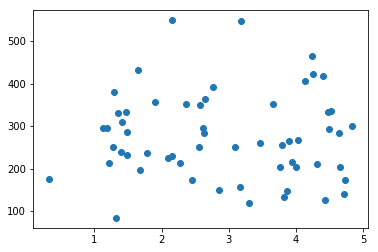

(-0.0230990047324023, 0.8633508967043587)


In [185]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats

data = read_sentences_and_reading_times('data/brown_reading_times.csv')

sentences = data[0]
reading_times = data[1]

train_corpus = open('data/bnc_10k.txt', 'r')

model_with_smoothing = arpa.loadf("data/bnc_10k_with_smoothing.arpa")[0]
vocab = set(model_with_smoothing.vocabulary())


times_bigrams = get_reading_times_and_bigrams(sentences, reading_times, train_corpus)

bigrams = times_bigrams[0]
reading_times = times_bigrams[1]

surprisal_list = []
reading_list = []

for index in range(len(bigrams)):
    bigram = list(bigrams[index])
    surprisal = compute_surprisal(model_with_smoothing, bigram, vocab)

    if surprisal is not None:
        reading_list.append(reading_times[index])
        surprisal_list.append(surprisal)

plt.scatter(surprisal_list, reading_list)
plt.show()
print(scipy.stats.pearsonr(surprisal_list, reading_list))

#### Question (d) Response:
My calculated correlation coefficient between surprisal and reading time was -0.0972, so there is very little negative correlation between the two, and the p value is very high (0.94), thus we are not very confident in our results. In the end, there's not much we can say about the correlation, it seems pretty uncorrelated.


### (e)

Using the same bigrams returned by `get_reading_times_and_bigrams` from part c, compute surprisal based on the BNC model **without** smoothing.

Generate a scatter plot and compute the linear correlation for the results without smoothing, as you did in part d. Do your results differ from the results in part d? If so, explain why, and if not, explain why not.

[('<s>', 'buffeted'), ('by', 'swirling'), ('swirling', 'winds'), ('winds', 'the'), ('the', 'little'), ('little', 'green'), ('green', 'biplane'), ('biplane', 'struggled'), ('struggled', 'northward'), ('northward', 'between')]
[723.76, 405.26, 367.21, 379.89, 339.24, 418.62, 351.24, 326.62, 771.31, 471.44]


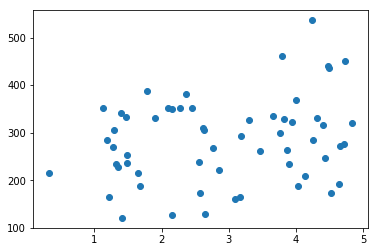

(0.24713785911988703, 0.06144207143527606)


In [186]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats

data = read_sentences_and_reading_times('data/brown_reading_times.csv')

sentences = data[0]
reading_times = data[1]

train_corpus = open('data/bnc_10k.txt', 'r')

model_without_smoothing = arpa.loadf("data/bnc_10k_no_smoothing.arpa")[0]
vocab = set(model_without_smoothing.vocabulary())


times_bigrams = get_reading_times_and_bigrams(sentences, reading_times, train_corpus)

bigrams = times_bigrams[0]
reading_times = times_bigrams[1]

surprisal_list = []
reading_list = []

for index in range(len(bigrams)):
    bigram = list(bigrams[index])
    surprisal = compute_surprisal(model_without_smoothing, bigram, vocab)

    if surprisal is not None:
        reading_list.append(reading_times[index])
        surprisal_list.append(surprisal)

plt.scatter(surprisal_list, reading_list)
plt.show()
print(scipy.stats.pearsonr(surprisal_list, reading_list))

The linear correlation for the two results without smoothing was 0.07 with an even higher p value (0.598), thus we are even less confident about this result than with the smoothed dataset. That being said, it is not actually significaintly different. This is because of the bigram_threshold, which is set to 75, it ensures that only common bigrams are used for surprisal calculations. These common bigrams are all in the unsmoothed data. When we reduce bigram_threshold to 0, our data has two seperate columns, is very different from the smoothed data and has a correlation of 0.02.

## Part 3: Surprisal and Concreteness

Given the experiments we've done so far, we don't really know if surprisal is connected to semantics. One prominent element of semantics that cognitive scientists have found plays a role in word processing is concreteness. In the next part of the problem, we'll look at the relationship between surprisal and concreteness. To do this, we'll use the Calgary Concreteness data set$^4$, which has several English nouns and their concreteness ratings on a scale from 1 to 5. This dataset is in `data/calgary_concreteness.csv`.  We provide the functions that read in info from this dataset in `provided_functions.py`. Using this data, we can compare the average surprisal of words that are relatively high in concreteness to those that are relatively low in concreteness, to see how concreteness affects reading times.


### (f)

Write a function `compute_average_word_surprisal`, which computes the average surprisal for a given word based on `max_bigrams` randomly selected contexts that that word occurs in in the BNC corpus.

Use the function `compute_average_word_surprisal` to find the average surprisal for the word *cat*.

In [171]:
from provided_functions import get_bigram_counts
from tqdm import tqdm
import numpy as np

def compute_average_word_surprisal(word, bigram_counter, model, max_bigrams=10):
    """
    word: string -- the word to compute average surprisal for
    bigram_counter: collections.Counter -- a Counter mapping bigram tuples to frequency in a corpus.
                    This can be comptued using the function get_bigram_counts in provided_functions.py
    model: arpa model -- an arpa model
    max_bigrams: int -- number of sampled bigrams used to compute the average surprisal of word
    
    Return the average surprisal of a bigram containing word in index 1. For example,
    for the word 'cat', we would consider ('my', 'cat') but not ('cat', 'went'). In cases where there
    are more than max_bigrams in bigram_counter that contain word in index 0, compute average surprisal
    based on max_bigrams randomly selected bigrams.
    """
    surprisal_list = []
    vocab = set(model.vocabulary())
    
    for bigram in bigram_counter:
        if bigram[1] == word:
            surprisal_list.append(compute_surprisal(model, bigram, vocab))

    if len(surprisal_list) <= max_bigrams:
        return np.mean(surprisal_list)

    else:
        final_surprisal_list = []
        for i in range(max_bigrams):
            random_index = random.randint(0, len(surprisal_list) - 1)
            final_surprisal_list.append(surprisal_list[random_index])
            del surprisal_list[random_index]
            
        return np.mean(final_surprisal_list)
        
bigram_counts = get_bigram_counts('data/bnc_10k.txt')
model_with_smoothing = arpa.loadf("data/bnc_10k_with_smoothing.arpa")[0]
compute_average_word_surprisal('cat', bigram_counts, model_with_smoothing)

6.5901537961723715

### (g)

Take a look at the files `data/low_concreteness_nouns.txt` and `data/high_concreteness_nouns.txt`. These files each contain a subset of 100 nouns from the Calgary Concreteness data set with low concreteness (< 2.5), high concreteness (> 3.5) respectively. They are the most common nouns of each type based on frequency in the BNC sample.

Use `matplotlib` to generate a scatter plot of surprisal vs. concreteness for the low concreteness nouns in `data/low_concreteness_nouns.txt`. You should use `compute_average_word_surprisal` from part f as well as the functions `load_words`, `get_bigram_counts`, and `read_concreteness` defined in `provided_functions.py`.


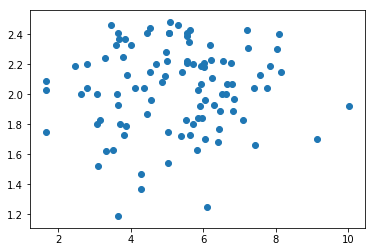

(0.058374956563435436, 0.5640052006199161)


In [134]:
from provided_functions import load_words, read_concreteness
from pprint import pprint
import matplotlib.pyplot as plt
import scipy
from scipy import stats

bigram_counts = get_bigram_counts('data/bnc_10k.txt')
model_with_smoothing = arpa.loadf("data/bnc_10k_with_smoothing.arpa")[0]


words = load_words('data/low_concreteness_nouns.txt')
concreteness = read_concreteness('data/calgary_concreteness.csv')

surprisal_averages = []
concreteness_list = []

for index in range(len(words)):
    surprisal_averages.append(compute_average_word_surprisal(words[index], bigram_counts, model_with_smoothing))
    word_index = concreteness[1].index(words[index])
    concreteness_list.append(concreteness[0][word_index])
        
plt.scatter(surprisal_averages, concreteness_list)
plt.show()
print(scipy.stats.pearsonr(surprisal_averages, concreteness_list))

### (h)

Use the same approach that you used in part g to generate a scatter plot of surprisal vs. concreteness the nouns in `data/high_concreteness_nouns.txt`.

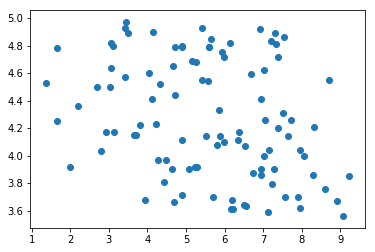

(-0.30468397377663925, 0.0020550010838876385)


In [135]:
from provided_functions import load_words, read_concreteness
from pprint import pprint
import matplotlib.pyplot as plt
import scipy
from scipy import stats

bigram_counts = get_bigram_counts('data/bnc_10k.txt')
model_with_smoothing = arpa.loadf("data/bnc_10k_with_smoothing.arpa")[0]


words = load_words('data/high_concreteness_nouns.txt')
concreteness = read_concreteness('data/calgary_concreteness.csv')

surprisal_averages = []
concreteness_list = []

for index in range(len(words)):
    surprisal_averages.append(compute_average_word_surprisal(words[index], bigram_counts, model_with_smoothing))
    word_index = concreteness[1].index(words[index])
    concreteness_list.append(concreteness[0][word_index])
        
plt.scatter(surprisal_averages, concreteness_list)
plt.show()
print(scipy.stats.pearsonr(surprisal_averages, concreteness_list))

### (i)

What is the relationship between surprisal and concreteness? Is the relationship different for high and low concreteness nouns? Explain why you think this is or is not the case.

#### (i) Solution:

There seems to be no correlation between the low concreteness nouns and suprisal, but there is a negative correlation between the high concreteness nouns and surprisal, i.e the higher the surprisal, the less suprised someone is, the more concrete the noun is. I have two possible explanations for this:

1. Concrete nouns refer to objects we encounter, and see everyday. We are generally more familiar with them, and do not need to think about them as much.
2. The frequency of concrete nouns in literature is higher than abstract nouns. Since the surprisal function is dependent on the context of the word, and most context (due to higher frequency) predict concrete nouns, and thus, surprisal is lower.

### Citations

$^1$Smith, N. J., & Levy, R. (2013). The effect of word predictability on reading time is logarithmic. Cognition, 128(3), 302-319. doi:10.1016/j.cognition.2013.02.013

$^2$The British National Corpus, version 3 (BNC XML Edition). 2007. Distributed by Bodleian Libraries, University of Oxford, on behalf of the BNC Consortium. URL: http://www.natcorp.ox.ac.uk/

$^3$A Standard Corpus of Present-Day Edited American English, for use with Digital Computers (Brown). 1964, 1971, 1979. Compiled by W. N. Francis and H. Kučera. Brown University. Providence, Rhode Island.

$^4$Pexman, P. M., Heard, A., Lloyd, E., & Yap, M. J. (2016). The Calgary semantic decision project: Concrete/abstract decision data for 10,000 English words. Behavior Research Methods, 49(2), 407-417. doi:10.3758/s13428-016-0720-6